# Data Wrangling with Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,asc
from pyspark.sql.types import StringType,IntegerType
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Instantiating a SparkSession
spark=SparkSession.builder.appName('Wrangling Data').getOrCreate()

In [4]:
# Let's load our json file into Spark DataFrame
user_log=spark.read.json('../data/sparkify_log_small.json')
type(user_log)

pyspark.sql.dataframe.DataFrame

## Data Exploration

In [8]:
# Reading the first 5 rows of the data
user_log.head(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [11]:
# Understanding the structure of the data, with the column name and the datatype
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# if describe() is used without show(), it behaves exactly the same as printSchema()
# show() tells us the summary, mean etc of different column values.
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [14]:
# Since, it's difficult to understand this format we can use a particular column 
# which we want to explore, say we want to explore the column 'artist'
# select() is used to select columns from the SDF
user_log.select('artist').describe().show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [15]:
# If we use it out numeric column we can get more insight about the data in the Column
user_log.select(['artist','sessionId']).describe().show()

+-------+-----------------+------------------+
|summary|           artist|         sessionId|
+-------+-----------------+------------------+
|  count|             8347|             10000|
|   mean|            461.0|         4436.7511|
| stddev|            300.0|2043.1281541827561|
|    min|              !!!|                 9|
|    max|ÃÂlafur Arnalds|              7144|
+-------+-----------------+------------------+



In [17]:
# To get the count of the number of rows
user_log.count()

10000

We can see for each `sessionID` we have an entry but same is not for the `artist`, and it makes sense as there won't be any value for the artist column if user doesn't play any song during a session.

In [22]:
# Let's see what sort of page requests we have for 'page'
# dropDuplicates to get unique values and sort is used for sorting.
user_log.select('page').dropDuplicates().sort('page',ascending=True).show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



Hence, these are the different page requests users can make. Let's explote those users who chose to downgrade the plan by exploring the `Submit Downgrade` option

In [23]:
user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [31]:
# Let's explore a particular user and it's activities
# can use show() as well but it doesn't return all the values and just the top 20
# collect() on the other hand return all the values along with new DataFrame
user_log.select(['userId','firstName','page','song']).where(user_log.userId=='1046').collect()

[Row(userId='1046', firstName='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstName='Kenneth', page='Home', song=None),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstName='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstName='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstName='Kenneth'

## Calculating Statistics by Hour

In [36]:
# Let's explore how many songs users are listening in a particular hour
# for this we need to convert timestamp to datetime from epoch time, 
# let's see the initial time format from 'ts'
user_log.select('ts').head(5)

[Row(ts=1513720872284),
 Row(ts=1513720878284),
 Row(ts=1513720881284),
 Row(ts=1513720905284),
 Row(ts=1513720913284)]

In [44]:
# defining a user defined f'n with the name gethour using lamda
get_hour=udf(lambda x:datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [55]:
# let's add a new column with name hour and perform computation using
# the above gethour f'n
user_log=user_log.withColumn('hour',get_hour(user_log.ts))

In [56]:
user_log.head(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='3'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000', hour='3')]

Hence, we can see that user played a particular song at 3:00 AM

In [68]:
# The next step is to count the next song page request, group by the hour we just computed
# and also let's order by hour to get in a correct format.
# inplace of sort() we can also use 'orderBy()''
songs_in_hour=user_log.filter(user_log.page=='NextSong').groupby('hour').count().sort(user_log.hour.cast('float'))

In [69]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  337|
|   1|  255|
|   2|  271|
|   3|  307|
|   4|  377|
|   5|  371|
|   6|  505|
|   7|  410|
|   8|  320|
|   9|  341|
|  10|  319|
|  11|  306|
|  12|  344|
|  13|  395|
|  14|  324|
|  15|  185|
|  16|  236|
|  17|  238|
|  18|  285|
|  19|  418|
+----+-----+
only showing top 20 rows



In [70]:
# Let's convert the above data into dataframe and plot the graph
songs_in_hr_pd=songs_in_hour.toPandas()

In [77]:
# hour is in object format let's convert it in float format
songs_in_hr_pd.hour=songs_in_hr_pd.hour.astype('int64')

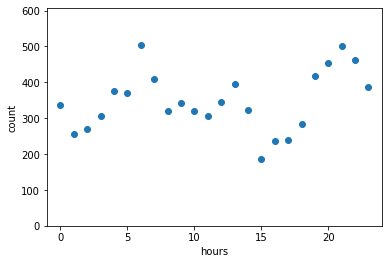

In [81]:
plt.scatter(songs_in_hr_pd['hour'],songs_in_hr_pd['count'])
plt.xlim(-1,24)
plt.ylim(0,1.2*max(songs_in_hr_pd['count']))
plt.xlabel('hours')
plt.ylabel('count')
plt.show()

## Remove Rows with Missing values

In [82]:
# We need to be sure that we have all the values for userId and the sessionID
user_log_valid=user_log.dropna(how='any',subset=['userId','sessionId'])

In [84]:
# Hence we can see that we have not lost any data as such
user_log.count(),user_log_valid.count()

(10000, 10000)

In [86]:
# let's have a look at userId unique values
user_log.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [88]:
# We see that the first entry is an empty string and we need to remove this record
# we can also use .filter() in place of where(), both perform the same task
user_log_valid=user_log_valid.where(user_log.userId!="")
user_log_valid.count()

9664

Hence, we see that we have lost few information

## Users Downgraded Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [90]:
user_log_valid.filter("page = 'Submit Downgrade'").show(2)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  16|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [92]:
# Hence we see that the user Kelly has downgraded her account
user_log_valid.select(['userId','firstName','page','level','song']).where("userId = '1138'").collect()

[Row(userId='1138', firstName='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

We see that when the user submits the downgrade request the level changes from Paid to Free

In [93]:
# Let's create another udf that flags if the page is submit Downgrade as 1
flagdowngrade=udf(lambda x : 1 if x=='Submit Downgrade' else 0,returnType=IntegerType())

In [94]:
user_log_valid=user_log_valid.withColumn('downgraded',flagdowngrade(user_log_valid.page))

In [95]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='3', downgraded=0)

In [96]:
from pyspark.sql import Window

Window functions are a way of combining the values of ranges of rows in a DataFrame. When defining the window we can choose how to sort and group (with the partitionBy method) the rows and how wide of a window we'd like to use (described by rangeBetween or rowsBetween).

In [97]:
# Reversing all the orders wrt to 'time' and rangeBetween is all the previous rows but no rows afterwards
windowval=Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)

In [98]:
user_log_valid=user_log_valid.withColumn('Phase',Fsum('downgraded').over(windowval))

In [100]:
user_log_valid.select(['userId','firstname','ts','page','level','downgraded','Phase']).where("userId=='1138'").sort('ts').collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', downgraded=0, Phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', downgraded=0, Phase=

## Some Quick Quiz 

Q1. Which page did user id "" (empty string) NOT visit?

In [109]:
user_log.select(['userId','firstname','page']).dropDuplicates().where("userId=''").collect()

[Row(userId='', firstname=None, page='Home'),
 Row(userId='', firstname=None, page='About'),
 Row(userId='', firstname=None, page='Login'),
 Row(userId='', firstname=None, page='Help')]

Q2. How many female users do we have in the data set?

In [117]:
user_log.select(['userId','firstname']).dropDuplicates().where("gender='F'").count()

462

Q3. How many songs were played from the most played artist

In [128]:
user_log.select(['userId','artist','song']).groupBy('artist').count().sort('count',ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|                Muse|   36|
|        Jack Johnson|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|          Lily Allen|   28|
|               Train|   28|
|Barry Tuckwell/Ac...|   28|
|           Metallica|   27|
|          Nickelback|   27|
|           Daft Punk|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



Q4. How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [129]:
songs_btw_home=udf(lambda ishome:int(ishome=='Home'),IntegerType())

In [130]:
usr_window=Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)

In [132]:
cumsum=user_log.filter((user_log.page=='NextSong') | (user_log.page=='Home')).select(['userId','page','ts']) \
        .withColumn('homevisit',songs_btw_home(user_log.page)) \
        .withColumn('period',Fsum('homevisit').over(usr_window))

In [133]:
cumsum.filter(cumsum.page=='NextSong').groupBy(['userId','period']).agg({'period':'count'}) \
        .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+



In [147]:
cumsum.select(['userId','page','ts','homevisit','period']).sort(desc('ts')).where('userId=="2294"').collect()

[Row(userId='2294', page='NextSong', ts=1513787467284, homevisit=0, period=0),
 Row(userId='2294', page='NextSong', ts=1513786920284, homevisit=0, period=0),
 Row(userId='2294', page='NextSong', ts=1513786737284, homevisit=0, period=0),
 Row(userId='2294', page='NextSong', ts=1513786461284, homevisit=0, period=0),
 Row(userId='2294', page='Home', ts=1513786339284, homevisit=1, period=1),
 Row(userId='2294', page='NextSong', ts=1513786261284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513786041284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513785806284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513785549284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513785330284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513785086284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513784808284, homevisit=0, period=1),
 Row(userId='2294', page='NextSong', ts=1513784296284, h

In [149]:
cumsum.filter(cumsum.page=='NextSong').groupBy(['userId','period']).agg({'period':'count'}) \
.show()

+------+------+-------------+
|userId|period|count(period)|
+------+------+-------------+
|  1436|     0|            2|
|  2088|     1|           13|
|  2162|     0|           19|
|  2162|     2|           15|
|  2294|     0|            4|
|  2294|     1|           17|
|  2294|     2|            3|
|  2294|     3|           16|
|  2294|     4|            4|
|  2294|     5|           11|
|  2904|     0|            1|
|   691|     1|            3|
|  1394|     0|            9|
|  1394|     1|           17|
|  2275|     0|            3|
|  2756|     0|            4|
|  2756|     2|            1|
|   451|     0|            1|
|   451|     1|            1|
|   800|     1|            2|
+------+------+-------------+
only showing top 20 rows

